# 실습1_사기탐지



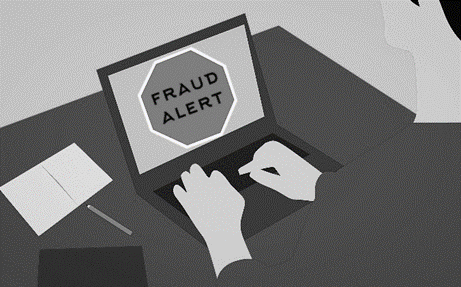

* 금융 사기거래 탐지
    * 20,000 건의 거래 내역 중 비정상 거래(사기거래)를 탐지하기 위한 데이터셋입니다.  

* 변수설명
    * x1~x18 : 금융정보 보호를 위해 PCA로 차원 축소시킨 feature들
    * amount : 거래금액(단위 : 달러)
    * fraud : 0 - normal, 1 - fraud(abnormal)
        * 0 : 19508건 (97.54%)
        * 1 : 492건 (2.46%)


## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV

from itertools import product
from tqdm import tqdm

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

### 2) 데이터셋 불러오기

In [3]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/creditcard_simple.csv"
data = pd.read_csv(path)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,amount,fraud
0,0.733,-0.544,-0.601,0.020,0.181,0.172,-1.768,-0.083,-0.323,0.110,-0.019,-0.457,-0.088,0.167,0.270,-0.513,-0.006,0.044,199.45,0
1,1.942,-0.056,1.319,1.197,0.367,0.265,0.006,0.310,-0.522,-0.223,-0.268,-0.595,0.345,-1.040,-0.432,0.280,-0.018,-0.057,1.98,0
2,-0.223,1.182,0.166,-1.328,0.151,-0.101,-0.489,0.476,0.034,-0.174,0.404,1.288,-0.076,0.071,-0.787,-0.218,0.382,0.259,0.89,0
3,0.672,-1.261,-0.602,-0.866,-0.335,0.875,0.786,0.012,1.338,0.655,0.201,0.078,-0.527,0.133,0.745,0.041,-0.074,0.049,340.31,0
4,-3.368,0.099,0.458,-1.572,0.672,-3.188,1.019,-0.590,1.930,0.265,0.861,1.249,1.851,-0.117,1.220,0.000,1.036,0.004,320.01,1


In [4]:
print(data['fraud'].value_counts())
print('='* 100)
print(data['fraud'].value_counts(normalize = True))

0    19508
1      492
Name: fraud, dtype: int64
0    0.9754
1    0.0246
Name: fraud, dtype: float64


## 2.데이터 준비

* 데이터 분할

In [5]:
target = 'fraud'
x = data.drop(target, axis = 1)
y = data[target]

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 6000, random_state=20)

In [7]:
x_train.shape, y_train.shape

((14000, 19), (14000,))

## 3.모델링1 : Resampling

* down, up, smote 중 하나를 정해서 사용하세요.

### (1) resampling

In [ ]:
down_sampler = RandomUnderSampler()
x_train_d, y_train_d = down_sampler.fit_resample(x_train, y_train)

In [ ]:
smote_sampler = SMOTE()
x_train_sm, y_train_sm = smote_sampler.fit_resample(x_train, y_train)

### (2) 모델링

In [ ]:
model1_1 = LogisticRegression()
model1_1.fit(x_train_d, y_train_d)

pred1_1 = model1_1.predict(x_val)
print(confusion_matrix(y_val, pred1_1))
print(classification_report(y_val, pred1_1))

[[5253  594]
 [  28  125]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      5847
           1       0.17      0.82      0.29       153

    accuracy                           0.90      6000
   macro avg       0.58      0.86      0.62      6000
weighted avg       0.97      0.90      0.93      6000



In [ ]:
model1_2 = LogisticRegression()
model1_2.fit(x_train_sm, y_train_sm)

pred1_2 = model1_2.predict(x_val)
print(confusion_matrix(y_val, pred1_2))
print(classification_report(y_val, pred1_2))

[[5333  514]
 [  33  120]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5847
           1       0.19      0.78      0.30       153

    accuracy                           0.91      6000
   macro avg       0.59      0.85      0.63      6000
weighted avg       0.97      0.91      0.93      6000



## 4.모델링2 : class weight 조정
* balanced
* 수동 조정


### (1) class_weight = 'balanced'

In [ ]:
y_train.value_counts(normalize = True)

0    0.975786
1    0.024214
Name: fraud, dtype: float64

In [ ]:
model2 = LogisticRegression(class_weight = 'balanced')
model2.fit(x_train, y_train)

pred2 = model2.predict(x_val)
print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

[[5285  562]
 [  27  126]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      5847
           1       0.18      0.82      0.30       153

    accuracy                           0.90      6000
   macro avg       0.59      0.86      0.62      6000
weighted avg       0.97      0.90      0.93      6000



### (2) class_weight = { 0:  , 1:}

In [ ]:
wt = np.linspace(0, 0.99, 100)
params = { 'class_weight':[{0:x, 1:1-x } for x in wt]}
params

In [ ]:
model2 = GridSearchCV(LogisticRegression(), params, cv = 5, scoring = 'f1')
model2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0}, {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98},
                                          {0: 0.03, 1: 0.97},
                                          {0: 0.04, 1: 0.96},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.06, 1: 0.94},
                                          {0: 0.07, 1: 0.9299999999999999},
                                          {0: 0.08, 1: 0.92},
                                          {0: 0.09, 1: 0.91}, {0: 0.1, 1: 0.9},
                                          {0: 0.11, 1: 0.89},
                                          {0: 0.12, 1: 0.88},
                                          {0: 0.13, 1: 0.87},
                                          {0: 0.14, 1: 0.86},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.16, 1: 0.84},
                                          {0: 0.17, 1: 0.83},
                                          {0: 0.18, 1: 0.8200000000000001},
                                          {0: 0.19, 1: 0.81}, {0: 0.2, 1: 0.8},
                                          {0: 0.21, 1: 0.79},
                                          {0: 0.22, 1: 0.78},
                                          {0: 0.23, 1: 0.77},
                                          {0: 0.24, 1: 0.76},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.26, 1: 0.74},
                                          {0: 0.27, 1: 0.73},
                                          {0: 0.28, 1: 0.72},
                                          {0: 0.29, 1: 0.71}, ...]},
             scoring='f1')

In [ ]:
result = pd.DataFrame(model2.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063670,0.002585,0.007257,0.002625,"{0: 0.0, 1: 1.0}","{'class_weight': {0: 0.0, 1: 1.0}}",0.046739,0.047420,0.047420,0.047420,0.047420,0.047284,0.000272,100
1,0.183194,0.015621,0.006271,0.000102,"{0: 0.01, 1: 0.99}","{'class_weight': {0: 0.01, 1: 0.99}}",0.147795,0.140980,0.169916,0.151177,0.153846,0.152743,0.009607,99
2,0.178743,0.020447,0.006729,0.000439,"{0: 0.02, 1: 0.98}","{'class_weight': {0: 0.02, 1: 0.98}}",0.278177,0.265446,0.266010,0.243119,0.253333,0.261217,0.011985,98
3,0.185678,0.021464,0.006150,0.000231,"{0: 0.03, 1: 0.97}","{'class_weight': {0: 0.03, 1: 0.97}}",0.393220,0.342857,0.330986,0.347826,0.334365,0.349851,0.022493,97
4,0.175824,0.023067,0.006148,0.000054,"{0: 0.04, 1: 0.96}","{'class_weight': {0: 0.04, 1: 0.96}}",0.500000,0.412451,0.417778,0.421053,0.387833,0.427823,0.037926,95


0.6499999999999999


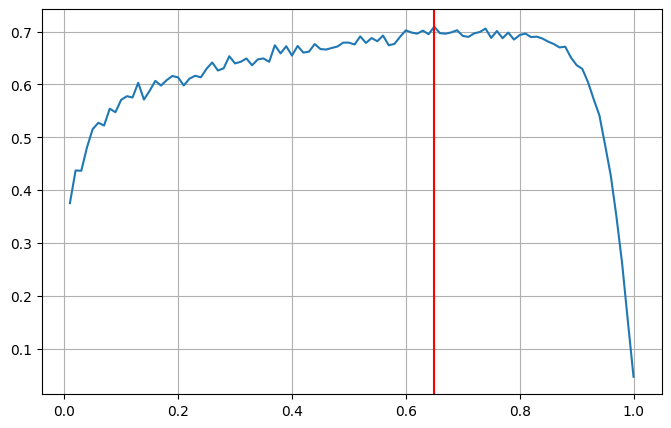

In [ ]:
wt1 = 1- wt
f1 = result['mean_test_score']
best_cw = model2.best_params_['class_weight'][1]

print(best_cw)
plt.figure(figsize = (8,5))
plt.plot(wt1, f1)
plt.axvline(best_cw, color = 'r')
plt.grid()
plt.show()

## 5.모델링3 : isolation forest
* 방법1 : contamination 값 조정
* 방법2 : score 산출 > cuff-off조정 > 잘라서 평가
* 튜닝 : 수동 grid search


### (1) 방법1 : contamination 값 조정

In [ ]:
y_train.value_counts(normalize = True)

0    0.975786
1    0.024214
Name: fraud, dtype: float64

In [ ]:
model = IsolationForest(contamination=0.0242)
model.fit(x_train)

IsolationForest(contamination=0.0242)

In [ ]:
# 예측
pred = model.predict(x_val)

# 결과를 1,0으로 변환(np.where)
pred = np.where( pred == 1  , 0 , 1  )

# 분류 결과를 평가해 봅시다.
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5727  120]
 [ 105   48]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5847
           1       0.29      0.31      0.30       153

    accuracy                           0.96      6000
   macro avg       0.63      0.65      0.64      6000
weighted avg       0.96      0.96      0.96      6000



### (2) 방법2 : score 산출 > cuff-off조정 > 잘라서 평가

#### 1) 스코어 계산하기

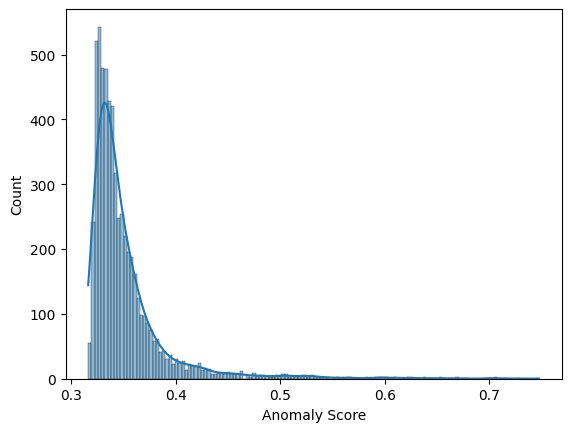

In [ ]:
# abnormal 점수 계산
val_score = model.score_samples(x_val)

# 0~1 의 값으로 score 바꾸기
val_score = -1 * val_score

# score의 분포 살펴보기
sns.histplot(val_score, kde= True)
plt.xlabel('Anomaly Score')
plt.show()

#### 2) 최적의 cut-off 찾기

##### ① prec_rec_f1_curve 함수 만들기
* sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.

In [ ]:
from sklearn.metrics import precision_recall_curve

def prec_rec_f1_curve(y, score, pos = 1) :

    # precision, recall, f1 계산
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label = pos)
    f1 = 2 / (1/precision + 1/recall)

    # 그래프 그리기
    plt.figure(figsize = (12,8))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')

    #-------------------------------------------------------------------------
    # 아래 코드는 차트 꾸미기 입니다.
    # f1를 최대화 해주는 threshold
    thre = round(thresholds[np.argmax(f1)],4)
    f1s = round(max(f1),4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline( f1s, color = 'darkred', linewidth = .7)
    plt.text(thre, .5, thre, color = 'darkred')
    plt.text(min(thresholds), f1s, f1s, color = 'darkred')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

##### ② 최적의 cut-off 찾기

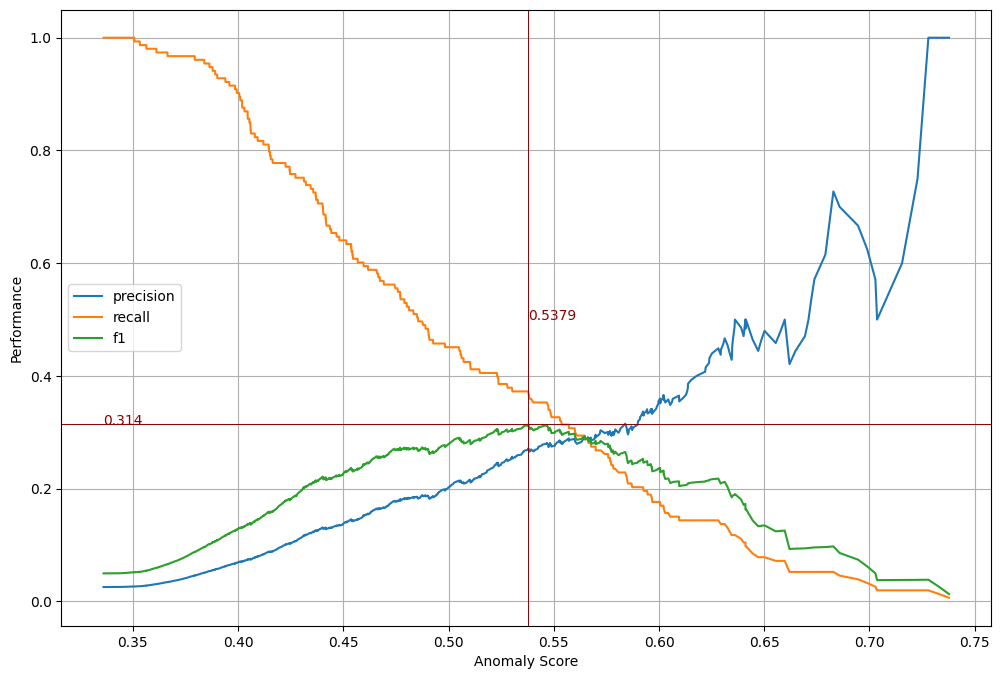

In [ ]:
# prec_rec_f1_curve 이용하여 최적의 cutoff 찾기
_, _, f1, thresholds = prec_rec_f1_curve(y_val, val_score)

##### ③ f1값을 최대화 하는 cut-off 값을 구해봅시다.

In [ ]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.5378588079354794

#### 3) cut-off값으로 나눠서 평가

In [ ]:
# 나누기
pred = np.where(val_score >= thres_f1_max, 1, 0)

In [ ]:
# 평가하기
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5694  153]
 [  96   57]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5847
           1       0.27      0.37      0.31       153

    accuracy                           0.96      6000
   macro avg       0.63      0.67      0.65      6000
weighted avg       0.97      0.96      0.96      6000



### (3) 튜닝 : 수동 grid search

In [ ]:
new_cont = sum(val_score >= thres_f1_max) / len(val_score)
new_cont

0.035

In [ ]:
# product 함수를 이용하여 값의 조합을 구성
cont = [0.02, 0.03, 0.04, 0.05]
m_sam = [500, 1000, 2000, 3000]
iter = list(product(cont, m_sam))
iter

[(0.02, 500),
 (0.02, 1000),
 (0.02, 2000),
 (0.02, 3000),
 (0.03, 500),
 (0.03, 1000),
 (0.03, 2000),
 (0.03, 3000),
 (0.04, 500),
 (0.04, 1000),
 (0.04, 2000),
 (0.04, 3000),
 (0.05, 500),
 (0.05, 1000),
 (0.05, 2000),
 (0.05, 3000)]

* 튜닝

In [ ]:
# 결과 저장 빈 리스트
f1_list = []

for i in tqdm(iter) :
    f1_temp = []

    # 동일한 값으로 모델 5번씩 만들기
    for j in range(5) :
        model = IsolationForest(contamination = i[0], max_samples = i[1])
        model.fit(x_train)
        pred = model.predict(x_val)
        pred = np.where(pred == 1, 0, 1)
        f1_temp.append(f1_score(y_val, pred, pos_label=1))

    # 평균 f1 계산해서 추가
    f1_list.append(np.mean(f1_temp))

# 최종 결과
result = pd.DataFrame({'cont, m_sam':iter, 'f1':f1_list})
result

100%|██████████| 16/16 [01:15<00:00,  4.72s/it]


,"cont, m_sam",f1
0,"(0.02, 500)",0.296548
1,"(0.02, 1000)",0.289905
2,"(0.02, 2000)",0.285359
3,"(0.02, 3000)",0.278373
4,"(0.03, 500)",0.328381
5,"(0.03, 1000)",0.331644
6,"(0.03, 2000)",0.314841
7,"(0.03, 3000)",0.323392
8,"(0.04, 500)",0.303579
9,"(0.04, 1000)",0.315113


In [ ]:
result.loc[result['f1'] == result['f1'].max()]

,"cont, m_sam",f1
5,"(0.03, 1000)",0.331644


## 6.모델링4 : one class SVM
* nu, gamma 각각 튜닝하며 경향성 확인
* 튜닝 : 수동 grid search


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [11]:
x_train0 = x_train_s[y_train == 0]

In [12]:
model = OneClassSVM()
model.fit(x_train0) # x_train 중에서도 normal 데이터만 학습에 사용!
pred = model.predict(x_val_s)
pred = np.where(pred == 1, 0, 1) # -1, 1 ==> 1, 0

print(confusion_matrix(y_val, pred))
print('-'*50)
print(classification_report(y_val, pred))

[[2899 2948]
 [  20  133]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.50      0.66      5847
           1       0.04      0.87      0.08       153

    accuracy                           0.51      6000
   macro avg       0.52      0.68      0.37      6000
weighted avg       0.97      0.51      0.65      6000



### (1) nu, gamma 각각 튜닝하며 경향성 확인

#### 1) nu 값 경향 확인하기

In [17]:
params = np.linspace(0.001,0.1,50)
f1 = []

for nu in tqdm(params) :
    model = OneClassSVM(nu = nu)
    model.fit(x_train0)
    pred = model.predict(x_val_s)
    pred = np.where(pred == 1, 0, 1)
    f1.append(f1_score(y_val, pred, pos_label= 1))

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


In [18]:
nu_f1_max = params[np.argmax(f1)]
nu_f1_max

0.013122448979591837

nu : 0.013122448979591837, f1_max : 0.3088235294117648


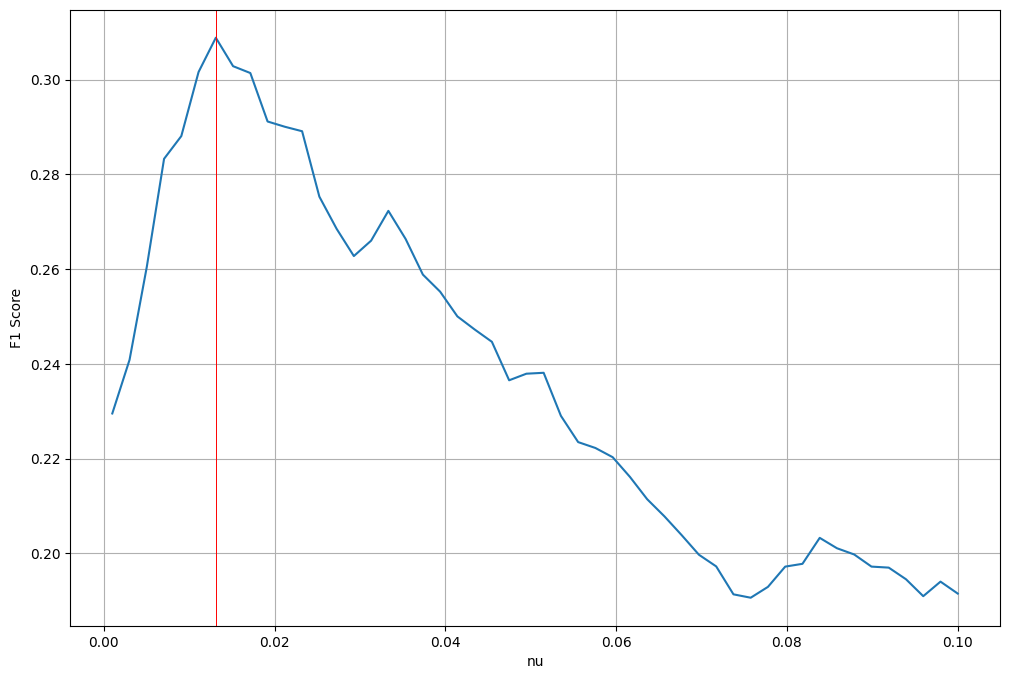

In [19]:
print( f'nu : {nu_f1_max}, f1_max : {max(f1)}')

plt.figure(figsize=(12, 8))
plt.plot(params, f1)
plt.axvline(nu_f1_max, color = 'r', linewidth = .7   )
plt.ylabel('F1 Score')
plt.xlabel('nu')
plt.grid()
plt.show()

#### 2) gamma 경향 확인하기

In [32]:
params = np.linspace(1, 30, 50)
f1 = []

for g in tqdm(params) :
    model = OneClassSVM(nu=0.013, gamma = g)
    model.fit(x_train0)
    pred = model.predict(x_val_s)
    pred = np.where(pred == 1, 0, 1)
    f1.append(f1_score(y_val, pred, pos_label= 1))

100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


In [33]:
ga_f1_max = params[np.argmax(f1)]
ga_f1_max

13.428571428571429

gamma : 13.428571428571429, f1_max : 0.3753846153846154


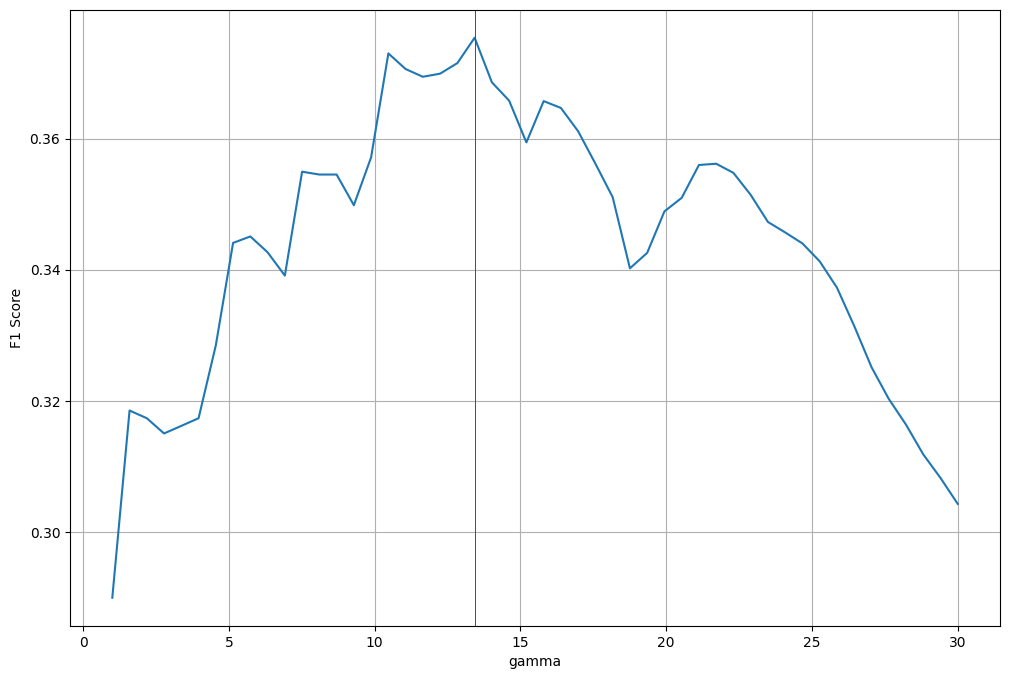

In [34]:
print( f'gamma : {ga_f1_max}, f1_max : {max(f1)}')

plt.figure(figsize=(12, 8))
plt.plot(params, f1)
plt.axvline(ga_f1_max, color = 'r', linewidth = .7   )
plt.ylabel('F1 Score')
plt.xlabel('gamma')
plt.grid()
plt.show()

### (2) 튜닝 : 수동 grid search

In [ ]:
# product 함수를 이용하여 값의 조합을 구성
nu = np.linspace(0.001, 0.02, 20)
gamma = np.linspace(10, 20, 10)
iter = list(product(nu, gamma))
iter

* 튜닝

In [38]:
# 결과 저장 빈 리스트
f1_list = []

for i in tqdm(iter) :

    model = OneClassSVM(nu = i[0], gamma = i[1])
    model.fit(x_train0)
    pred = model.predict(x_val_s)
    pred = np.where(pred == 1, 0, 1)
    f1_list.append(f1_score(y_val, pred, pos_label=1))

# 최종 결과
result = pd.DataFrame({'nu, gamma':iter, 'f1':f1_list})
result

100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


,"nu, gamma",f1
0,"(0.001, 10.0)",0.387097
1,"(0.001, 11.11111111111111)",0.393220
2,"(0.001, 12.222222222222221)",0.384365
3,"(0.001, 13.333333333333334)",0.378882
4,"(0.001, 14.444444444444445)",0.368580
...,...,...
195,"(0.02, 15.555555555555555)",0.353591
196,"(0.02, 16.666666666666668)",0.351064
197,"(0.02, 17.77777777777778)",0.347826
198,"(0.02, 18.88888888888889)",0.345679


In [39]:
result.loc[result['f1'] == result['f1'].max()]

,"nu, gamma",f1
1,"(0.001, 11.11111111111111)",0.39322
